# LB05: Кластеризация и снижение размерности

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, ноябрь 2021 </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемые к материалу датасеты лицензия не распространяется. 

В данной лабораторной работе вам предлагается познакомиться с методами кластеризации и понижения размерности. Для этого будем использовать 2 игрушечных датасета

1. Некоторые характеристики посетителей торгового центра
2. MNIST - легендарный и баянистый датасет фотографий рукописных цифр. 9 из 10 DS когда-либо классифицировали эти цифры (и вы тоже). Он неплохо подходит для ознакомления на практике с задачей кластеризации, чем мы и воспользуемся.


Базовая оценка за лабораторную без всех опциональных заданий - 8. Единственное опционально задание может превратить оценку в 9. А еще одно из трех на выбор в оценку 10.


# Дополнительные материалы по кластеризации

1. https://habr.com/company/ods/blog/325654/ - про все
2. https://www.youtube.com/watch?v=oWRmzf9eI-c - про кластеризацию (сложно)
3. http://www.ccas.ru/voron/download/Clustering.pdf - про кластеризацию (сложно)
5. https://habr.com/post/321216/ - еще про кластеризацию

+ +Ссылки на демо из лекции

## Задание 0. Загрузка данных

In [1]:
from sklearn.datasets import load_digits
import pandas as pd

MNIST можно получить следующим образом. С датасетом вы уже знакомы, поэтому останавливаться подробно на разведочном анализе уже не будем.

In [2]:
mnist = load_digits()
print(mnist['DESCR'])
X_mnist = mnist['data']
y_mnist = mnist['target']

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

А вот датасет клиентов торгового центра для вас новый. Давайте на нем ненадолго остановимся. В нем всего 4 столбца с признаками:
1. Пол
2. Возраст
3. Годовой доход
4. Spending Score (1-100). Некая числовая характеристика трат человека на основе данных, которые на напрямую недоступны.

Проведите этому датасету базовый набор анализов и продемонстрируйте результаты. 

In [3]:
customers = pd.read_csv('customers.csv')

In [4]:
customers.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

<AxesSubplot:xlabel='Gender'>

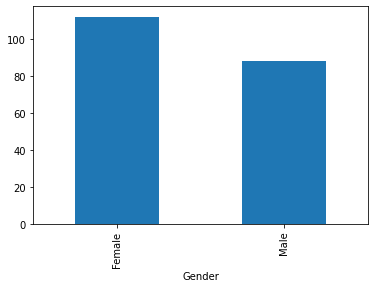

In [5]:
customers.groupby('Gender').size().plot.bar()

<AxesSubplot:>

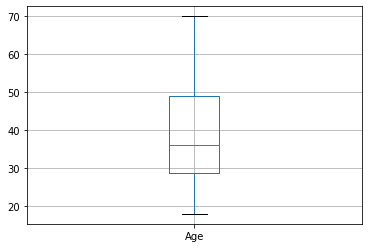

In [6]:
customers.boxplot(column = 'Age')

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Gender'>

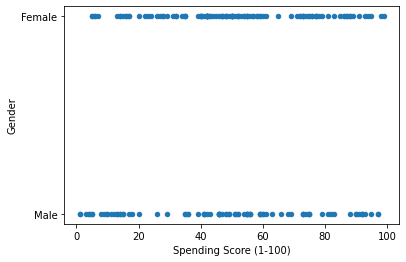

In [7]:
customers.plot.scatter(y = 'Gender',x = 'Spending Score (1-100)',)

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Gender'>

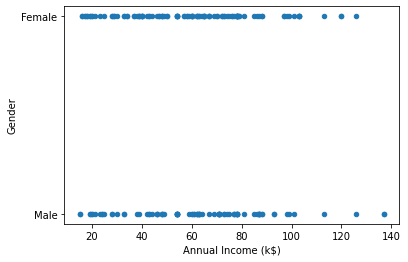

In [8]:
customers.plot.scatter(y = 'Gender',x = 'Annual Income (k$)',)

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

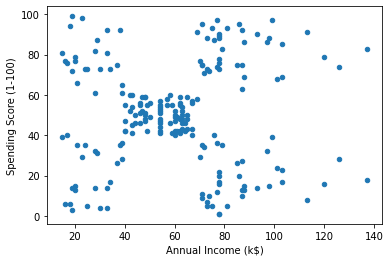

In [9]:
customers.plot.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)')

In [10]:
new_customers = pd.get_dummies(customers, drop_first = True)
new_customers = new_customers.drop('CustomerID',axis = 1)
new_customers.head()

Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0   19                  15                      39            1
1   21                  15                      81            1
2   20                  16                       6            0
3   23                  16                      77            0
4   31                  17                      40            0

## Статистика Хопкинса

На лекции мы с вами уже обсуждали эту статистику. Имплементировать ее я вас не прошу, а предоставляю готовую функцию. Ниже ссылки на теоретические материалы для тех, кому захочется разобраться еще подробнее.

1. http://www.sthda.com/english/wiki/assessing-clustering-tendency-a-vital-issue-unsupervised-machine-learning
2. http://datascience.stackexchange.com/questions/14142/cluster-tendency-using-hopkins-statistic-implementation-in-python
во второй ссылке есть указание публикации Validating Clusters using the Hopkins Statistic from IEEE 2004, которую тоже можно найти при желании.

In [11]:
import numpy as np

from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

Вот эта функция реализует вычисление статистики Хопкинса.
Это исправленная версия кода, представленного на stackoverflow. Для быстрого поиска ближайших соседей используется [k-мерное дерево](https://ru.wikipedia.org/wiki/K-d_дерево).

Кроме того, теперь есть полезный для работы с кластеризацией пакет, содержащий другую реализацию статистики Хопкинса https://github.com/lachhebo/pyclustertend. Можете использовать и его.


In [12]:
def hopkins_statistic(X, m_fraction=1):
    d = X.shape[1]
    n = X.shape[0]
    m = int(m_fraction * n)
    X_scaled = StandardScaler().fit_transform(X)
    X_sample = X_scaled[np.random.choice(range(0, n), m, replace=False)]
    neighbors = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(X_scaled)
    Y_rand = np.random.uniform(-1, 1, size=(m, d))
    y = []
    x = []
    for j in range(0, m):
        y.append(neighbors.kneighbors(Y_rand[j].reshape(1, -1),
                                      n_neighbors=1,
                                      return_distance=True)[0][0][0])
        x.append(neighbors.kneighbors(X_sample[j].reshape(1, -1),
                                      n_neighbors=2,
                                      return_distance=True)[0][0][1])

    H = sum(y) / (sum(x) + sum(y))
    return 1 - H

In [13]:
blobs, y = datasets.make_blobs(n_samples=5000, n_features=2,
                               centers=[(-10, -10), (0, 0), (10, 0)])
uni = np.random.uniform(-1,1, size=(5000, 2))

1. Чем ближе к 0, тем более выраженная кластерная структура (значение меньше 0.25 означает 90% вероятность наличия кластерной структуры)
2. Чем ближе к 0.5, тем больше данные похожи на шум. Может не очень хорошо работать в пространствах с большой размерностью
3. Если статистика близка к единице, то в данных есть какая-то структура, но не кластерная

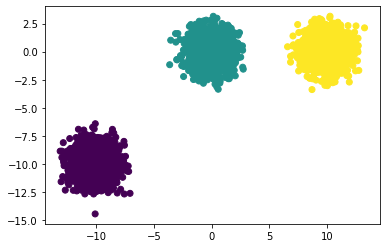

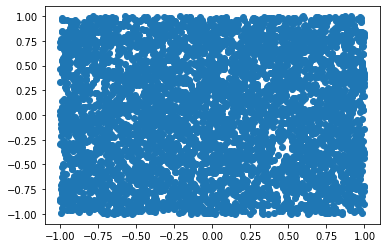

In [14]:
# Обратите внимание, каким образом я нарисовал кластеры разными цветами.
# Используйте этот способ дальше по лабе
plt.scatter(blobs[:,0], blobs[:,1], c=y)
plt.show()
plt.scatter(uni[:,0], uni[:,1])

# Часть 1. Кластеризация

Во втором датасете известно априорно оптимальное (вам предстоит узнать, оптимальное ли оно на самом деле) число кластеров: раз цифр 10, то логично предположить, что и кластеров будет 10. Поэтому будет проще, однако вам будет предложено посмотреть на результаты кластеризации и при другом числе кластеров и сделать выводы. 

Число кластеров для датасета покупателей неизвестно. Вам предстоит его выяснить на основе, например, анализа силуэтов.

## Задание предварительное. Оценка наличия кластерной структуры

С помощью функции для вычисления статистики Хопкинса проверьте датасеты на наличие кластерной структуры. Сделайте выводы и будьте готовы отвечать на вопросы о сути статистики.

P.s. Не надо волноваться, если значения статистики будут не очень хорошими, особенно для цифр.


In [15]:
hopkins_statistic(X_mnist)

0.3848796221212192

In [16]:
hopkins_statistic(new_customers)

0.323924798821849

## Задание 1.1. Кластеризация методом k-средних

С помощью метода k-средних проведите кластеризацию на датасетах. Сначала зафиксируем число кластеров как 2 (для покупателей) и 10 (для цифр).

Поскольку для методов кластеризации не нужны реальные метки, вместо fit и predict у методов кластеризации реализована сразу функция fit_predict. Т.е. predicted_labels = kmeans.fit_predict(X_scaled).

X_scaled потому что данные вам нужно перед кластеризацией стандартизировать.

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score

Ваша задача - провести кластеризацию и измерить метрики качества. Будем считать коэффициент силуэта и индекс гомогенности(второй только для цифр).

Также нужно отрисовать график силуэтов. Пример того, как это сделать в sklearn дан вот тут:

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


Очень надеюсь, что вы оформите повторяющиеся куски кода в функции, а не будете их копировать из одного места в другое. А еще больше надеюсь, что вы сможете расскзать мне значения параметров, которые используете и свяжите их с тем, что было в лекции.

Давайте теперь попробуем забыть о метках и том, что их 10. В цикле сделайте кластеризацию с количеством кластеров от 5 до 15 (или больше?). В каждом случае нарисуйте графики силуэтов и напечатайте средний силуэт. Сделайте вывод о наилучшем числе кластеров в данной задаче.


Аналогичным образом попробуйте обнаружить оптимальное число кластеров для покупателей.

In [18]:
import matplotlib.cm as cm

In [19]:
scaler_mnist = StandardScaler()
scaler_cust = StandardScaler()
X_mnist_scaled = scaler_mnist.fit_transform(X_mnist)
customers_scaled = scaler_cust.fit_transform(new_customers)

In [20]:
kmeans_mnist = KMeans(n_clusters = 10,init = 'random', random_state=10)
labels = kmeans_mnist.fit_predict(X_mnist_scaled)
print("silhouette score: "+ str(silhouette_score(X_mnist_scaled,labels)))
sample_silhouette_values = silhouette_samples(X_mnist_scaled,labels)
print("homogeneity: "+ str(homogeneity_score(y_mnist,labels)))

silhouette score: 0.1451173069224355
homogeneity: 0.6718972607177709


In [21]:
def kmeans_analysis(nclusters,X, y = [None]):
    fig, ax1 = plt.subplots()
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (nclusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=nclusters,init = 'random', random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        nclusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(nclusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

For n_clusters = 10 The average silhouette_score is : 0.1451173069224355


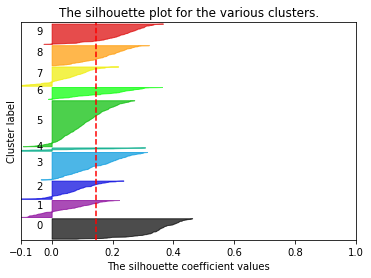

In [22]:
kmeans_analysis(10,X_mnist_scaled)

For n_clusters = 5 The average silhouette_score is : 0.09989868373842466


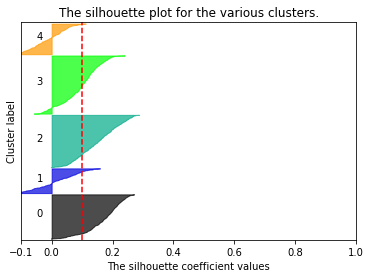

For n_clusters = 6 The average silhouette_score is : 0.11470995214313677


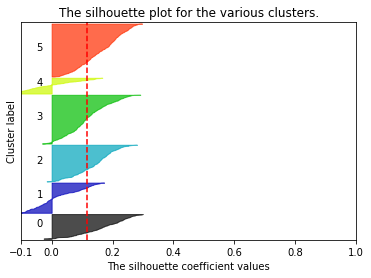

For n_clusters = 7 The average silhouette_score is : 0.1178634363283828


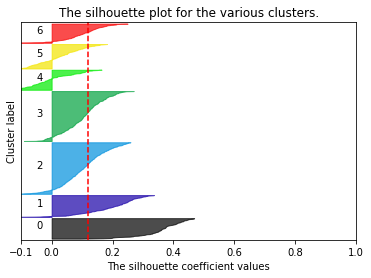

For n_clusters = 8 The average silhouette_score is : 0.12409888864378948


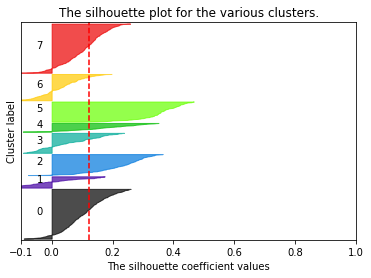

For n_clusters = 9 The average silhouette_score is : 0.13896455912081976


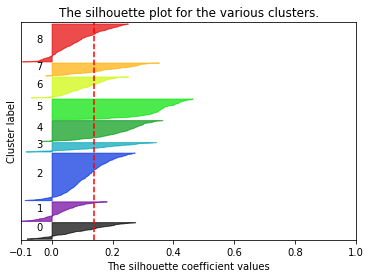

For n_clusters = 10 The average silhouette_score is : 0.1451173069224355


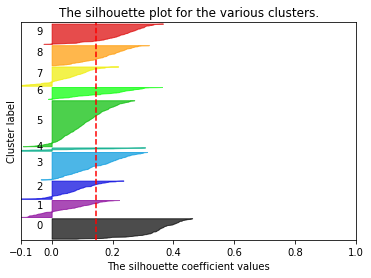

For n_clusters = 11 The average silhouette_score is : 0.14813553523571335


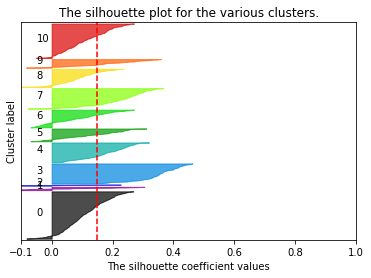

For n_clusters = 12 The average silhouette_score is : 0.15952900950425936


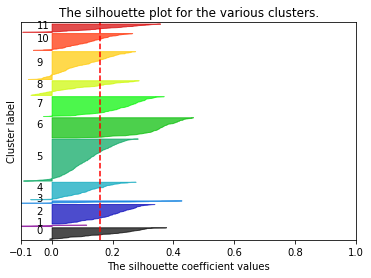

For n_clusters = 13 The average silhouette_score is : 0.14688672112698273


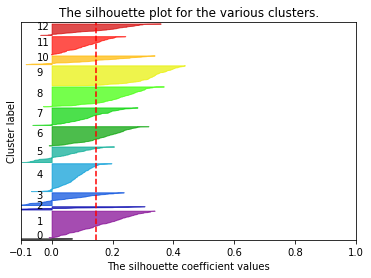

For n_clusters = 14 The average silhouette_score is : 0.15037100462806094


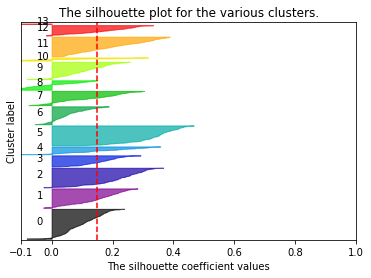

For n_clusters = 15 The average silhouette_score is : 0.1501148468924709


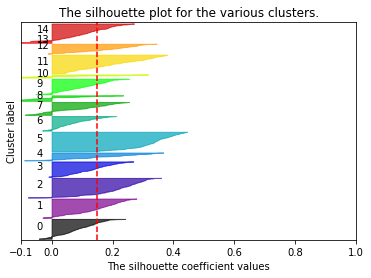

In [23]:
for i in range(5,16):
    kmeans_analysis(i,X_mnist_scaled)

For n_clusters = 2 The average silhouette_score is : 0.2518152915788437


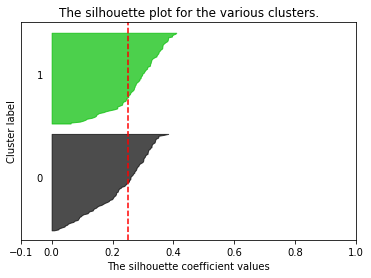

For n_clusters = 3 The average silhouette_score is : 0.24842786934974662


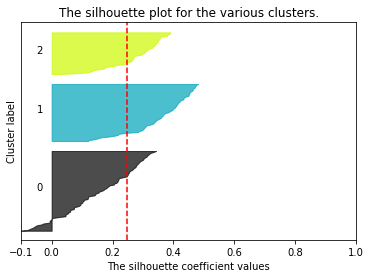

For n_clusters = 4 The average silhouette_score is : 0.29676146947439397


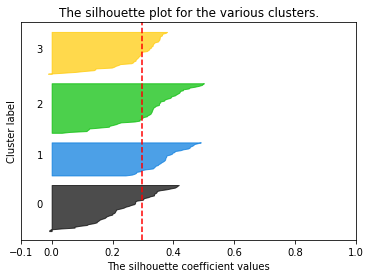

For n_clusters = 5 The average silhouette_score is : 0.3179935980678763


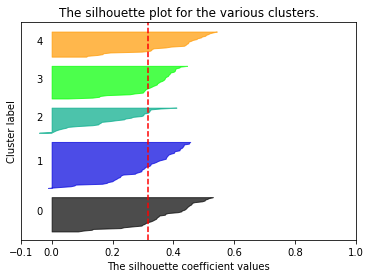

For n_clusters = 6 The average silhouette_score is : 0.33252815017028153


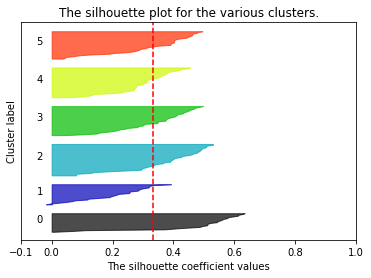

For n_clusters = 7 The average silhouette_score is : 0.359871716869106


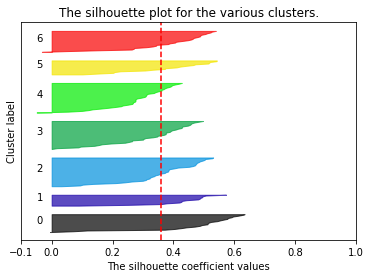

For n_clusters = 8 The average silhouette_score is : 0.3703141800711344


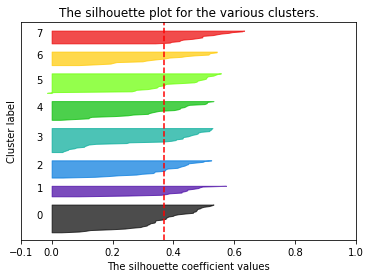

For n_clusters = 9 The average silhouette_score is : 0.4027213674010831


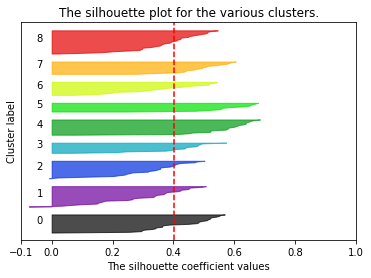

For n_clusters = 10 The average silhouette_score is : 0.42076374869477745


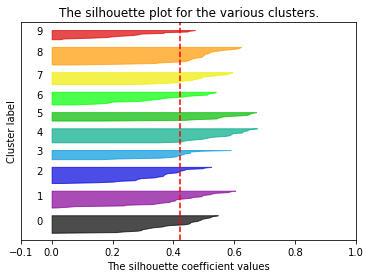

For n_clusters = 11 The average silhouette_score is : 0.42554439495060253


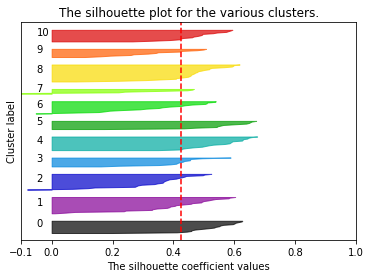

For n_clusters = 12 The average silhouette_score is : 0.41922759036378765


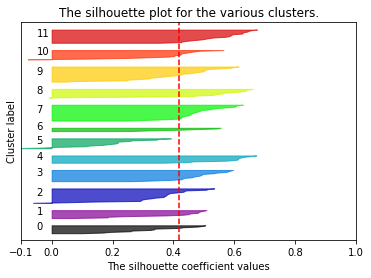

For n_clusters = 13 The average silhouette_score is : 0.42215458511495313


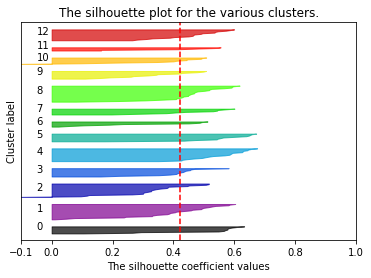

For n_clusters = 14 The average silhouette_score is : 0.4056642404509138


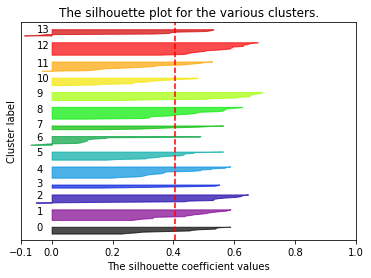

For n_clusters = 15 The average silhouette_score is : 0.41572881384039406


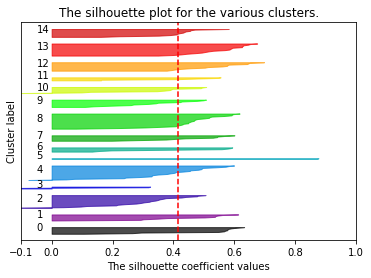

In [24]:
for i in range(2,16):
    kmeans_analysis(i,customers_scaled)

In [25]:
customer_pred = KMeans(n_clusters = 8,init = 'random', random_state=10).fit_predict(customers_scaled)

## Задание 1.2 Алгомеративная иерархическая кластеризация

Кластеризация другая, а задача та же. Обучите, посчитайте, пошатайте параметры, сравните, сделайте выводы. Вперед!

Считаем, что используем расстояние Уорда по умолчанию, но будет красиво, если вы стравните с другими.


In [26]:
from sklearn.cluster import AgglomerativeClustering

In [27]:
from scipy.cluster.hierarchy import dendrogram,linkage

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Нарисуйте и проанализируйте дендрограмму кластеризации. Пример того, как этом можно сделать, но ничто вас не ограничивает сделать иначе:

https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

Кроме того, принимающий преподаватель будет недоволен, если на дендрограмме будет невозможно что-то понять.

silhouette score: 0.12532527779196986


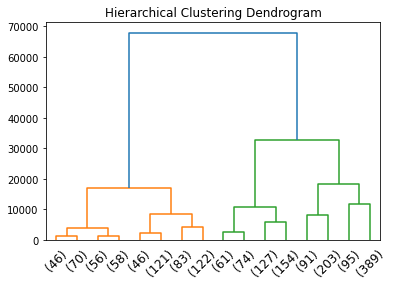

<Figure size 720x720 with 0 Axes>

In [28]:
model = AgglomerativeClustering(n_clusters=10)
model = model.fit(X_mnist_scaled)
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model.children_, 'ward')
dendrogram(Z,truncate_mode='level', p = 3)
# plot_dendrogram(model,labels=model.labels_,truncate_mode='level', p = 5)
plt.tick_params(axis='x', rotation=45)
plt.figure(figsize=(10,10))
print("silhouette score: "+ str(silhouette_score(X_mnist_scaled,model.labels_)))
plt.show()

silhouette score: 0.26322605188202447


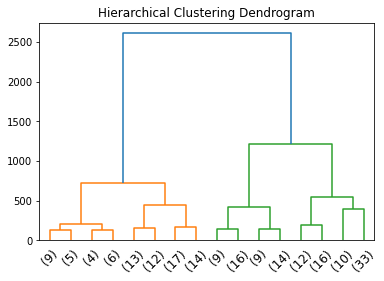

In [29]:
plt.clf()
model1 = AgglomerativeClustering(n_clusters=4)
model1 = model1.fit(customers_scaled)
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model1.children_, 'ward')
dendrogram(Z,truncate_mode='level', p = 3)
plt.tick_params(axis='x', rotation=45)
print("silhouette score: "+ str(silhouette_score(customers_scaled,model1.labels_)))
plt.show()

silhouette score: 0.3857382002204226


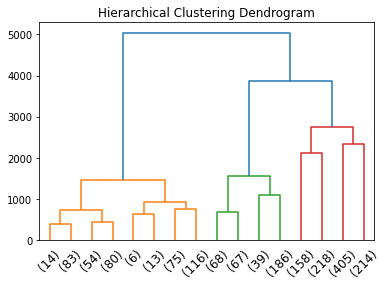

In [30]:
model = AgglomerativeClustering(n_clusters=10,linkage = 'complete')
model = model.fit(X_mnist_scaled)
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model.children_, 'complete')
dendrogram(Z,truncate_mode='level', p = 3)
# plot_dendrogram(model,labels=model.labels_,truncate_mode='level', p = 5)
plt.tick_params(axis='x', rotation=45)
print("silhouette score: "+ str(silhouette_score(X_mnist_scaled,model.labels_)))
plt.show()

silhouette score: 0.5317322123880858


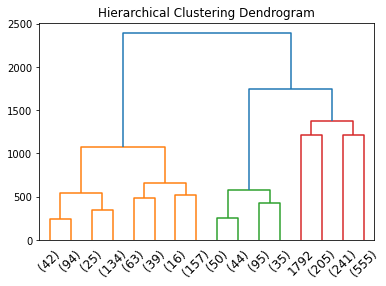

In [74]:
model = AgglomerativeClustering(n_clusters=10,linkage = 'average')
model = model.fit(X_mnist_scaled)
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model.children_, 'average')
dendrogram(Z,truncate_mode='level', p = 3)
# plot_dendrogram(model,labels=model.labels_,truncate_mode='level', p = 5)
plt.tick_params(axis='x', rotation=45)
print("silhouette score: "+ str(silhouette_score(X_mnist_scaled,model.labels_)))
plt.show()

silhouette score: 0.4711199596264649


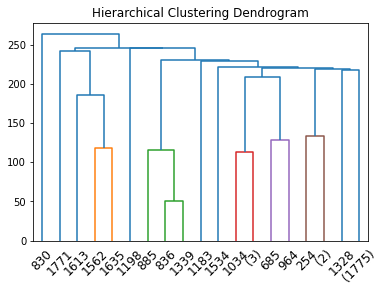

In [32]:
model = AgglomerativeClustering(n_clusters=10,linkage = 'single')
model = model.fit(X_mnist_scaled)
# plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model.children_, 'single')
dendrogram(Z,truncate_mode='level', p = 8)
# plot_dendrogram(model,labels=model.labels_,truncate_mode='level', p = 5)
plt.tick_params(axis='x', rotation=45)
print("silhouette score: "+ str(silhouette_score(X_mnist_scaled,model.labels_)))
plt.show()

## Задание 1.3 (Для оценки 9) Применение DBSCAN

В этом необязательном задании вам предлагается изучить алгоритм кластеризации DBSCAN, который имеет две важных особенности:
1. Самостоятельное определение числа кластеров
2. Способность не относить некоторые объекты ни к одному из кластеров.

Материалы для ознакомления:
1. http://www.machinelearning.ru/wiki/images/5/52/Voron-ML-Clustering-SSL-slides.pdf (раздел про DBSCAN)
2. https://habr.com/en/post/322034/


Сам алгоритм использовать в реализации sklearn. Для полученной кластеризации сделать аналогичный анализ по метрикам качества. Для наглядности примените DBSCAN после понижения размерности (задание 2.4) для того, чтобы посмотреть, какие объекты и как отнесены к выбросам в рамках простой двумерной визуализации.

In [44]:
 from sklearn.cluster import DBSCAN

0.27471113


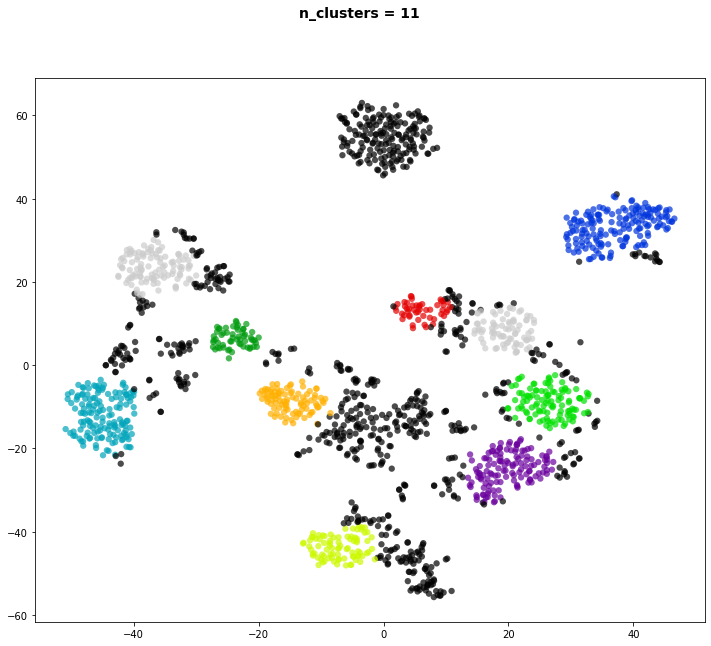

In [45]:
db_m = DBSCAN(eps = 4, min_samples = 40)
db_pred_m1 = db_m.fit_predict(pred_tsne)
n_clusters_ = len(set(db_pred_m1)) - (1 if -1 in db_pred_m1 else 0)
plt.figure(figsize=(12,10)) 
plt.scatter(pred_tsne[:, 0], pred_tsne[:, 1], c = db_pred_m1,
edgecolor='none', alpha=0.7, s=40, 
cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
plt.suptitle(("n_clusters = %d" % n_clusters_),fontsize=14, fontweight='bold')
print(silhouette_score(pred_tsne,db_pred_m1))

0.3914912
0.54678816
0.50945014
0.27471113
-0.15177417


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

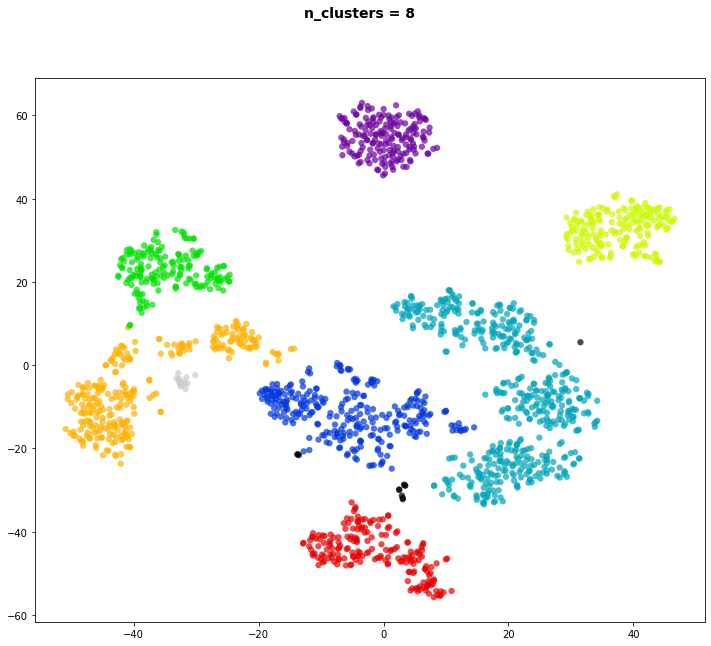

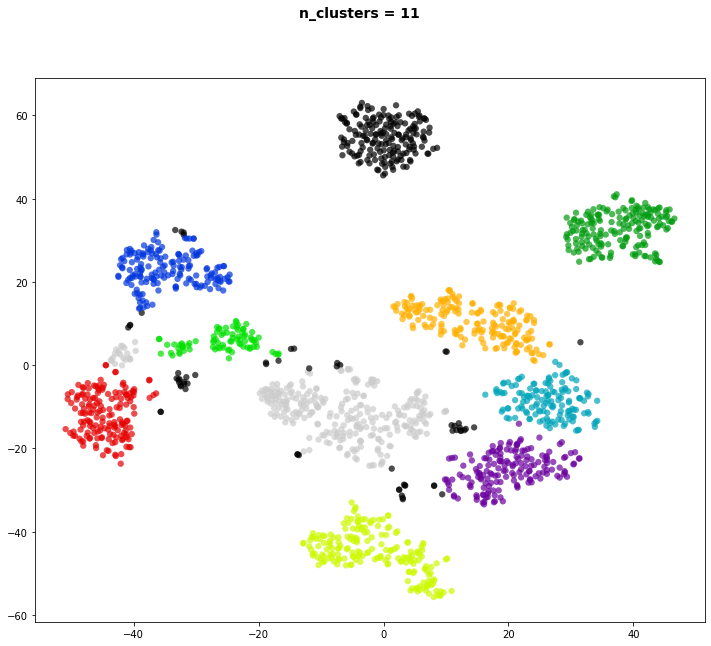

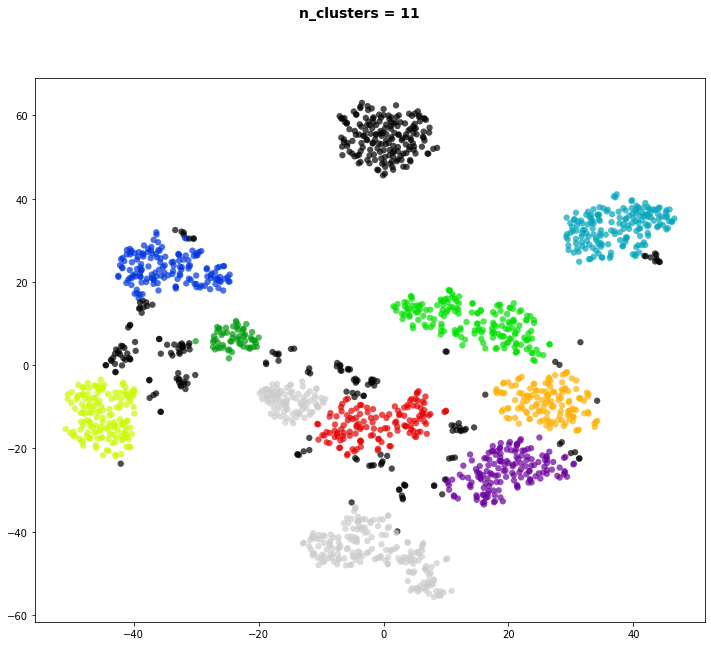

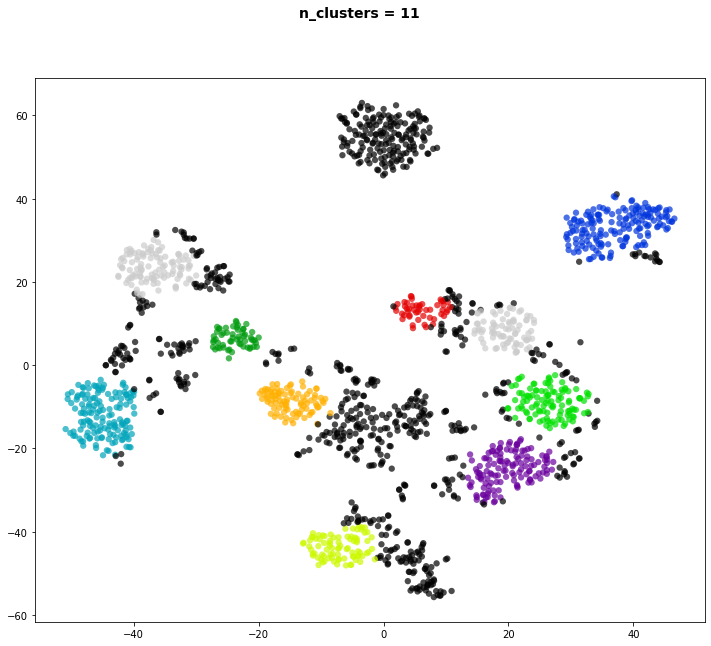

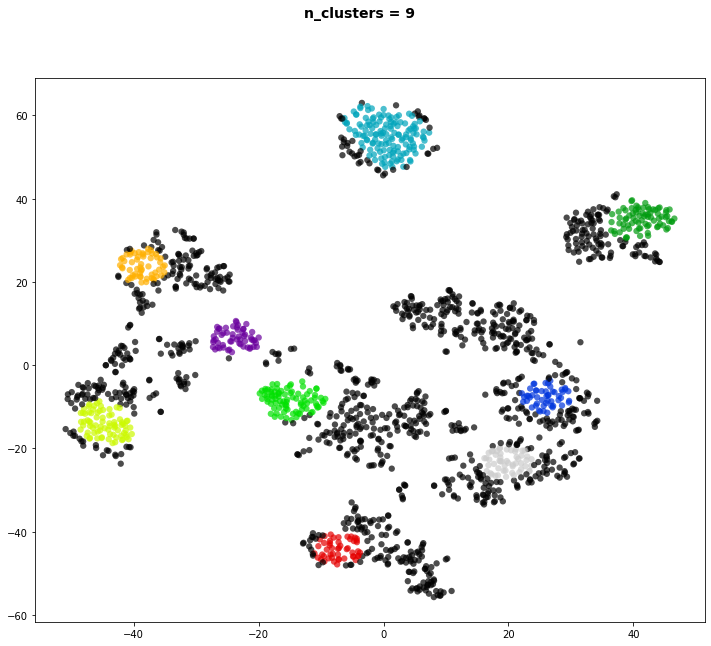

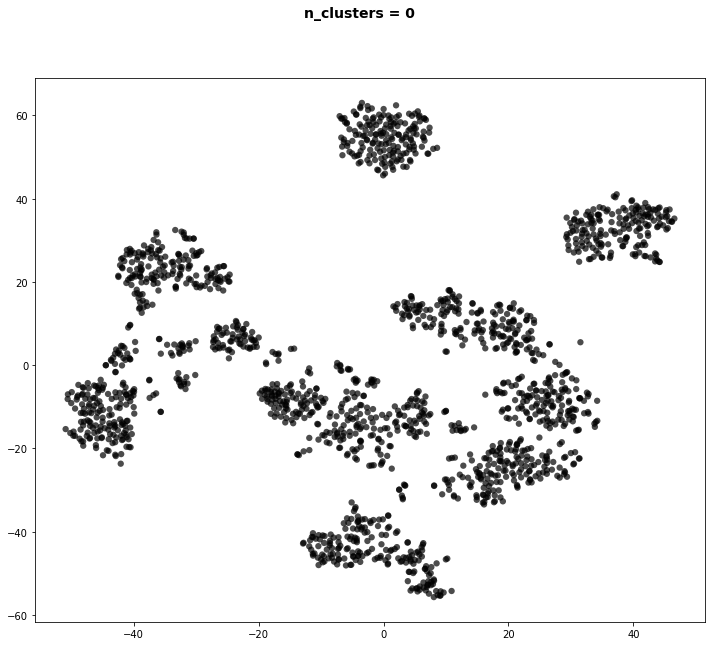

In [50]:
for i in range(10,70,10):
    db_m = DBSCAN(eps = 4, min_samples = i)
    db_pred_m1 = db_m.fit_predict(pred_tsne)
    n_clusters_ = len(set(db_pred_m1)) - (1 if -1 in db_pred_m1 else 0)
    plt.figure(figsize=(12,10)) 
    plt.scatter(pred_tsne[:, 0], pred_tsne[:, 1], c = db_pred_m1,
    edgecolor='none', alpha=0.7, s=40, 
    cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
    plt.suptitle(("n_clusters = %d" % n_clusters_),fontsize=14, fontweight='bold')
    print(silhouette_score(pred_tsne,db_pred_m1))

-0.8014292
0.00034302077
0.17593274
0.036071964
0.20537683
0.17610487
0.2134147
0.2863763
0.16787444
0.36133546


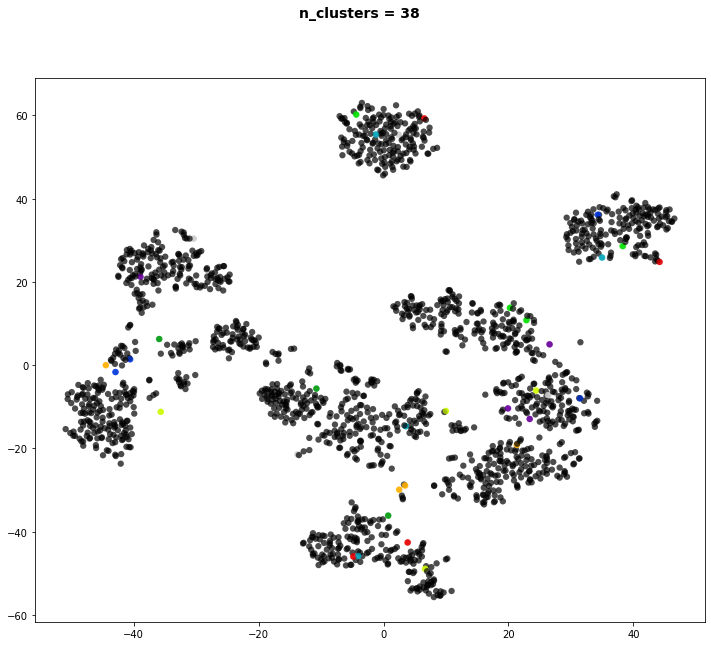

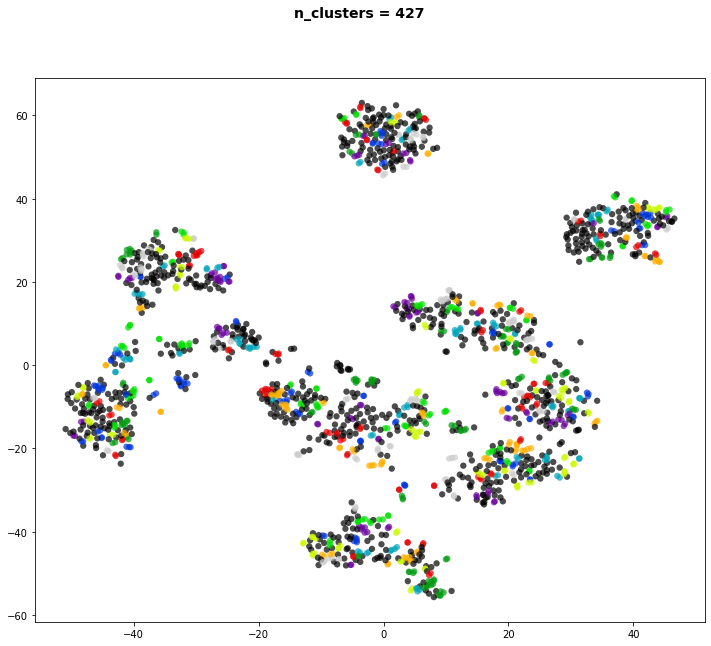

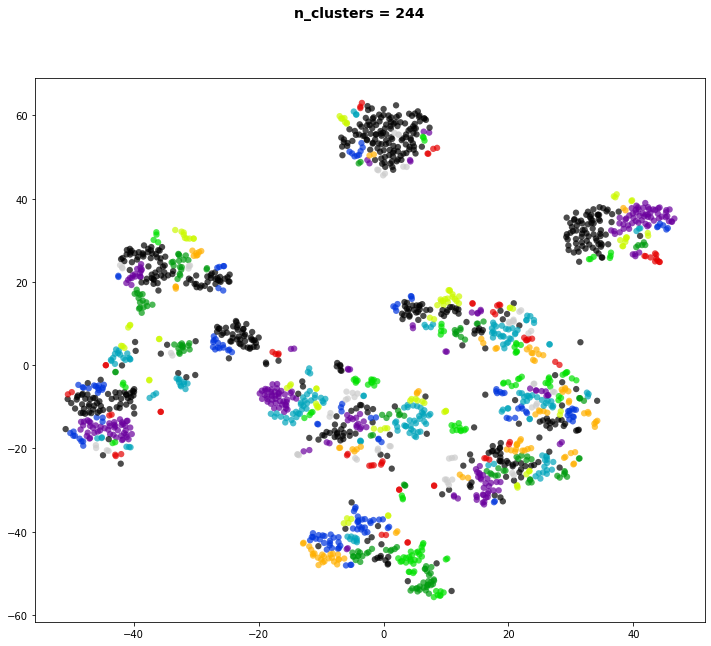

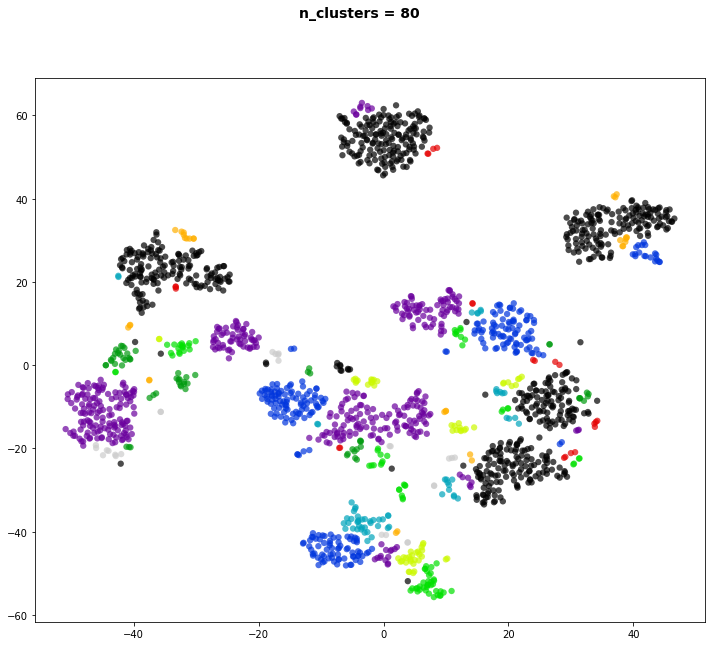

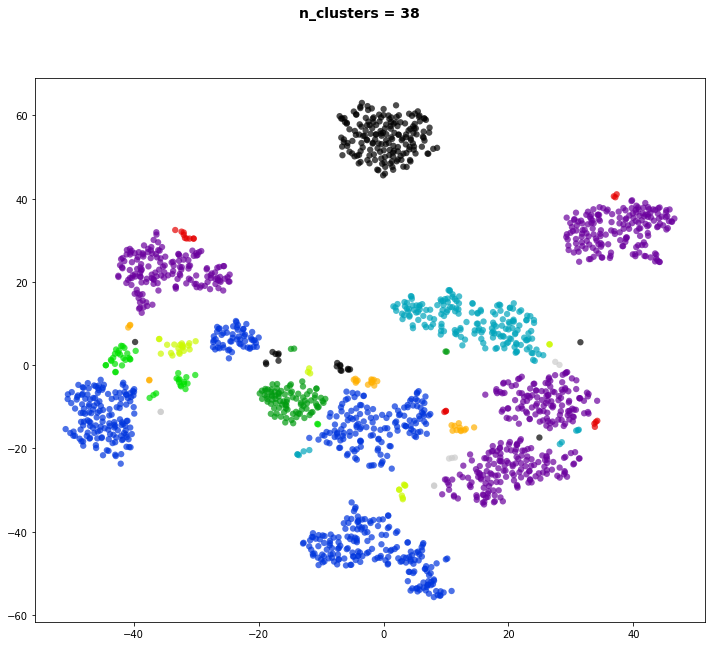

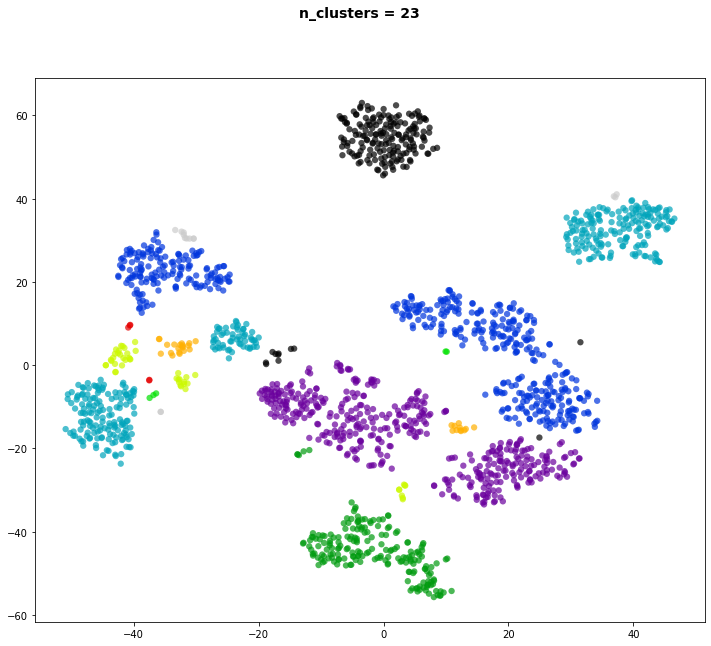

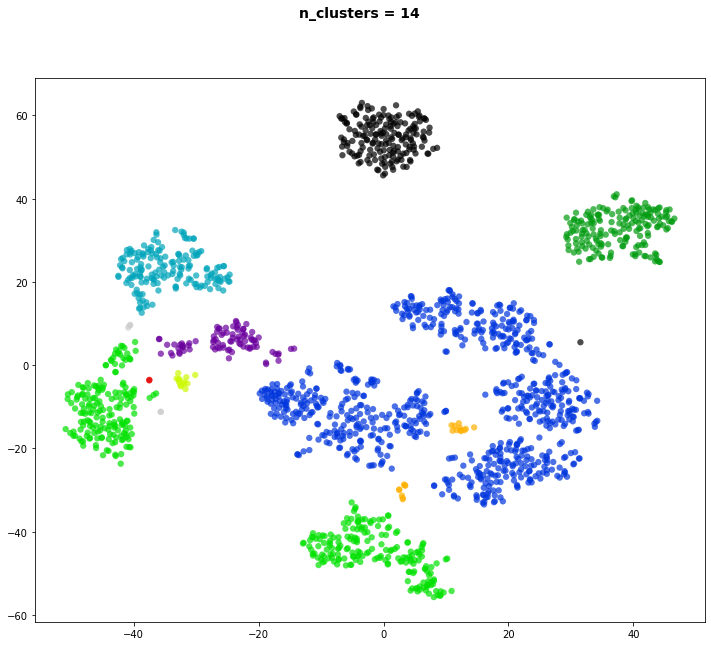

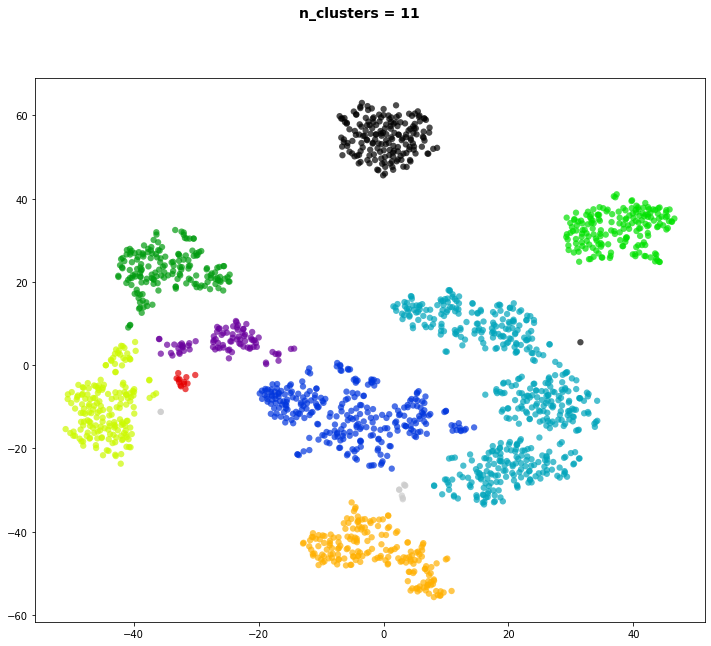

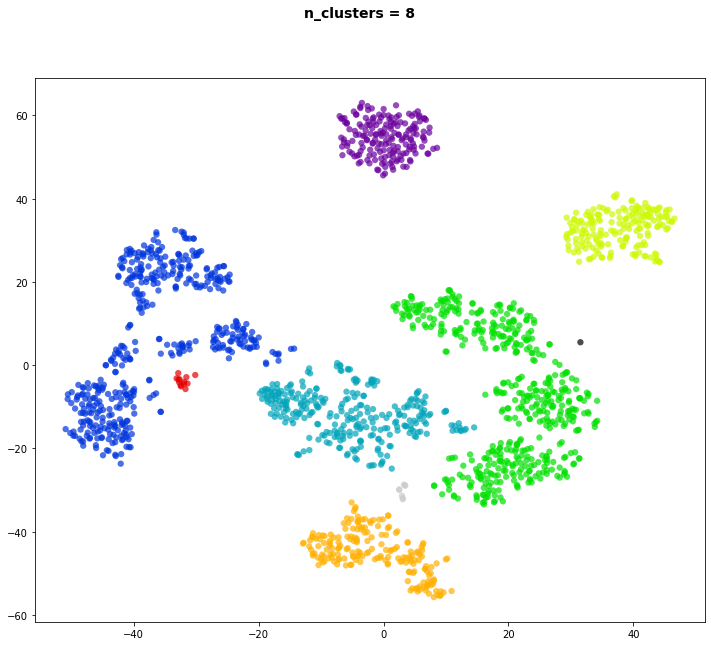

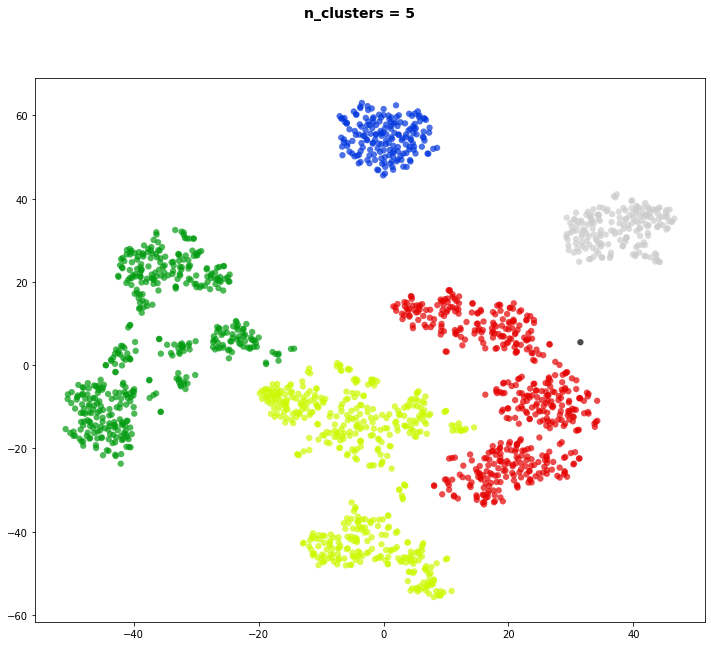

In [79]:
for i in np.arange(0.1,5,0.5):
    db_m = DBSCAN(eps = i, min_samples = 2)
    db_pred_m1 = db_m.fit_predict(pred_tsne)
    n_clusters_ = len(set(db_pred_m1)) - (1 if -1 in db_pred_m1 else 0)
    plt.figure(figsize=(12,10)) 
    plt.scatter(pred_tsne[:, 0], pred_tsne[:, 1], c = db_pred_m1,
    edgecolor='none', alpha=0.7, s=40, 
    cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
    plt.suptitle(("n_clusters = %d" % n_clusters_),fontsize=14, fontweight='bold')
    print(silhouette_score(pred_tsne,db_pred_m1))

0.5862709933072319
0.0025190782690573538


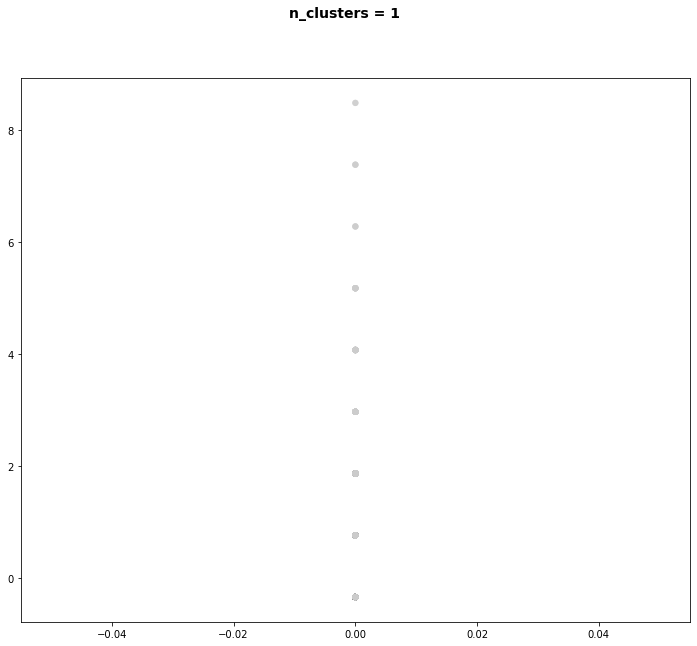

In [145]:
db_m = DBSCAN(eps = 9, min_samples = 20)
db_pred_m1 = db_m.fit_predict(X_mnist_scaled)
n_clusters_ = len(set(db_pred_m1)) - (1 if -1 in db_pred_m1 else 0)
plt.figure(figsize=(12,10)) 
# plot_digits(X_mnist_scaled,y_mnist,db_pred_m1)
plt.scatter(X_mnist_scaled[:, 0], X_mnist_scaled[:, 1], c = db_pred_m1,
edgecolor='none', alpha=0.7, s=40, 
cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
plt.suptitle(("n_clusters = %d" % n_clusters_),fontsize=14, fontweight='bold')
print(silhouette_score(X_mnist_scaled,db_pred_m1))
print(homogeneity_score(y_mnist,db_pred_m1))

0.043582395


<Figure size 432x288 with 0 Axes>

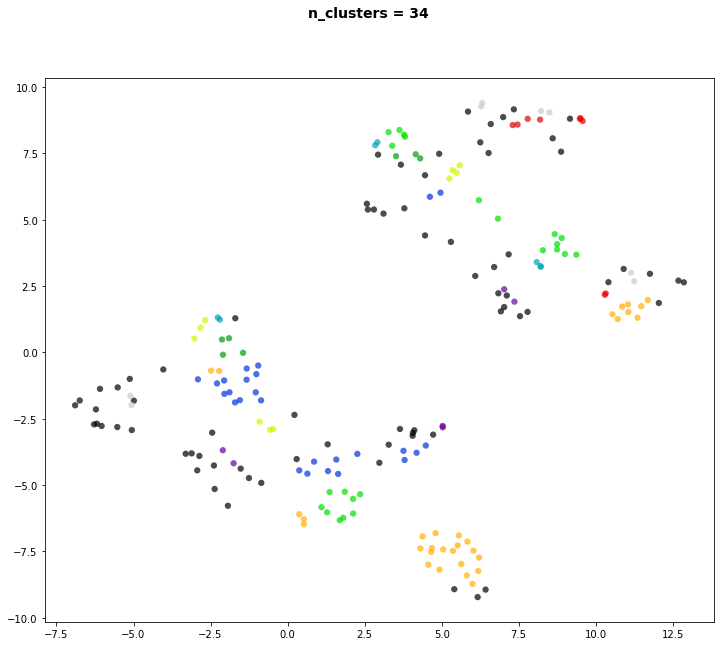

-0.07926259


<Figure size 432x288 with 0 Axes>

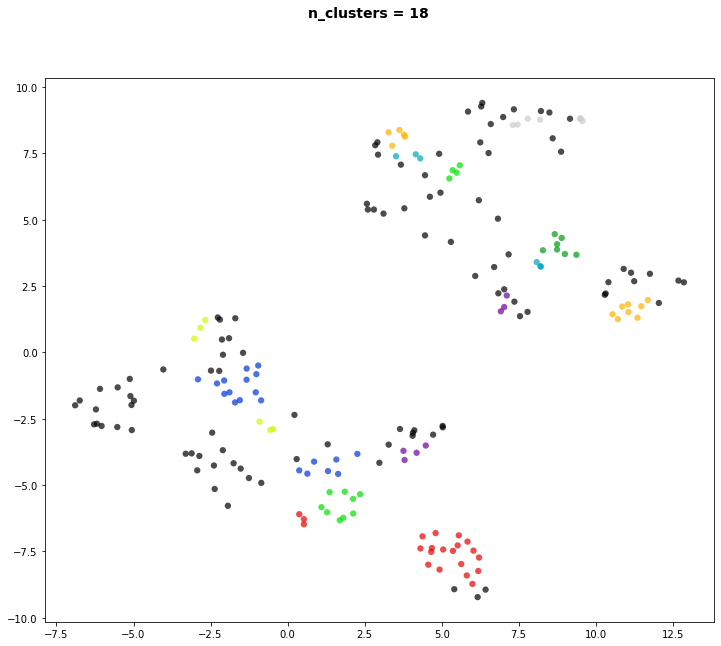

-0.25153133


<Figure size 432x288 with 0 Axes>

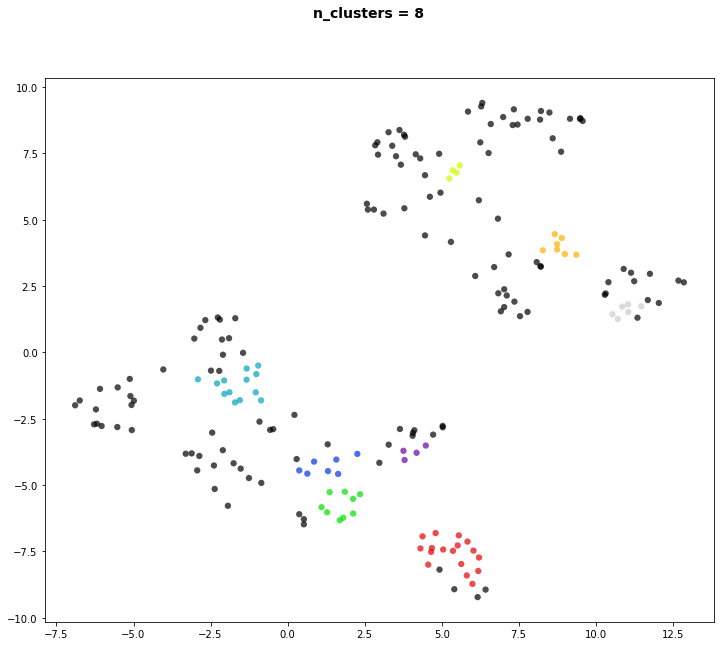

-0.36724144


<Figure size 432x288 with 0 Axes>

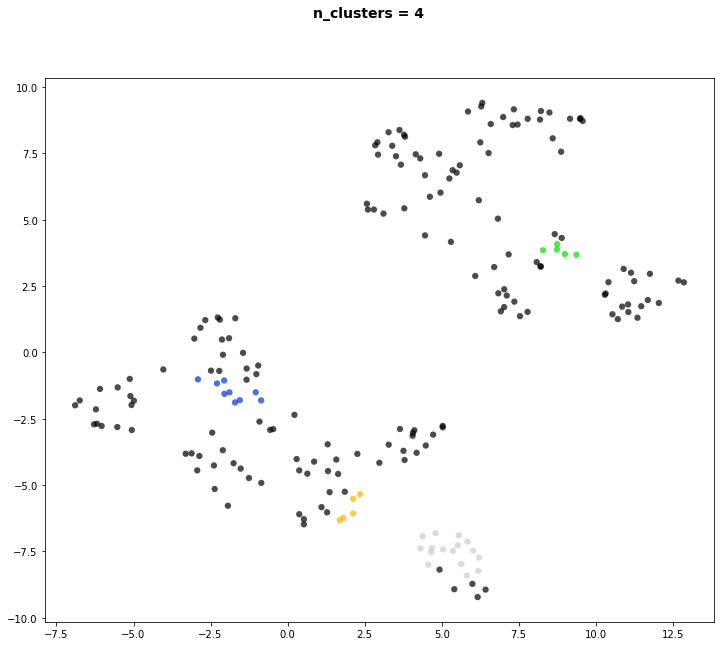

-0.08198157


<Figure size 432x288 with 0 Axes>

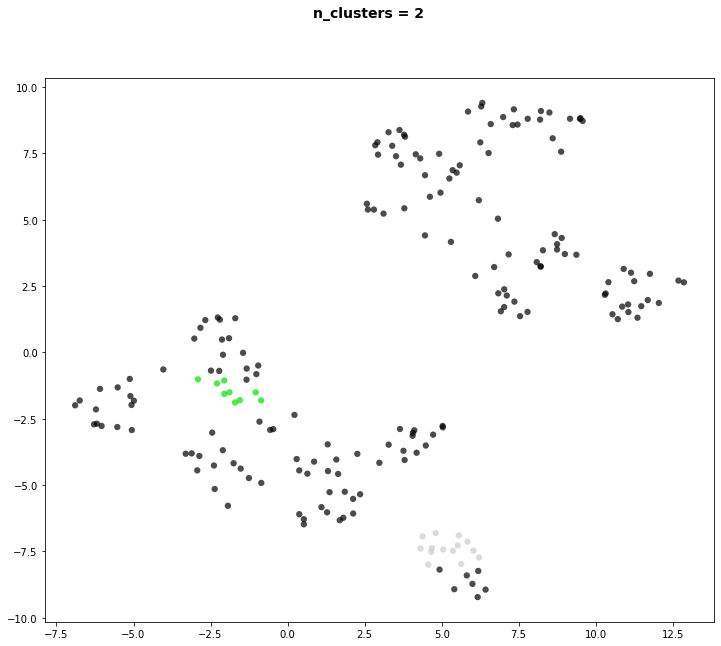

-0.13280705


<Figure size 432x288 with 0 Axes>

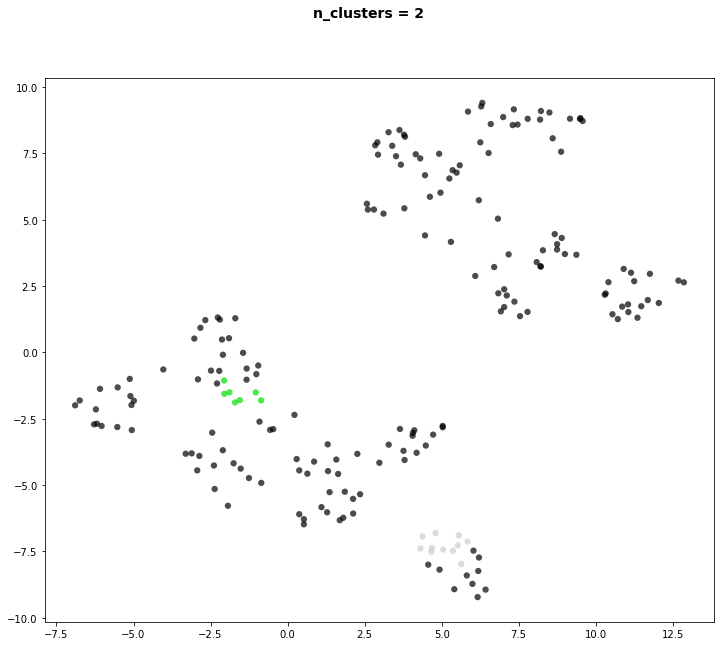

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

<Figure size 432x288 with 0 Axes>

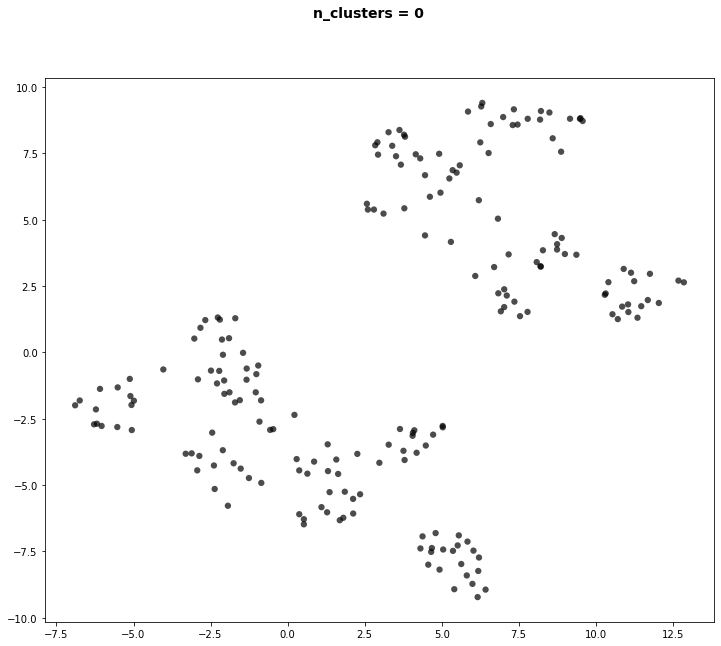

In [88]:
for i in range(2,9):
    plt.clf()
    db_mc = DBSCAN(eps = 0.4, min_samples =i)
    db_pred_m11 = db_mc.fit_predict(customers_scaled)
    n_clusters1_ = len(set(db_pred_m11)) - (1 if -1 in db_pred_m11 else 0)
    plt.figure(figsize=(12,10)) 
    plt.scatter(pred_tsne_cust[:, 0], pred_tsne_cust[:, 1], c=db_pred_m11, 
     edgecolor='none', alpha=0.7, s=40, 
     cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
    plt.suptitle(("n_clusters = %d" % n_clusters1_),
                         fontsize=14, fontweight='bold')
    print(silhouette_score(pred_tsne_cust,db_pred_m11))
    plt.show()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

<Figure size 432x288 with 0 Axes>

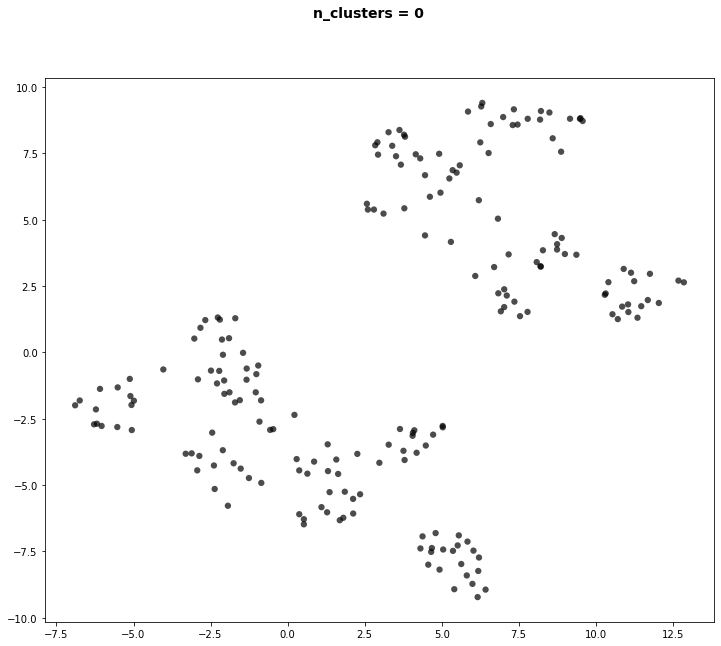

In [83]:
for i in np.arange(0.1,6,0.5):
    plt.clf()
    db_mc = DBSCAN(eps = i)
    db_pred_m11 = db_mc.fit_predict(customers_scaled)
    n_clusters1_ = len(set(db_pred_m11)) - (1 if -1 in db_pred_m11 else 0)
    plt.figure(figsize=(12,10)) 
    plt.scatter(pred_tsne_cust[:, 0], pred_tsne_cust[:, 1], c=db_pred_m11, 
     edgecolor='none', alpha=0.7, s=40, 
     cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
    plt.suptitle(("n_clusters = %d" % n_clusters1_),
                         fontsize=14, fontweight='bold')
    print(silhouette_score(pred_tsne_cust,db_pred_m11))
    plt.show()

-0.5287644


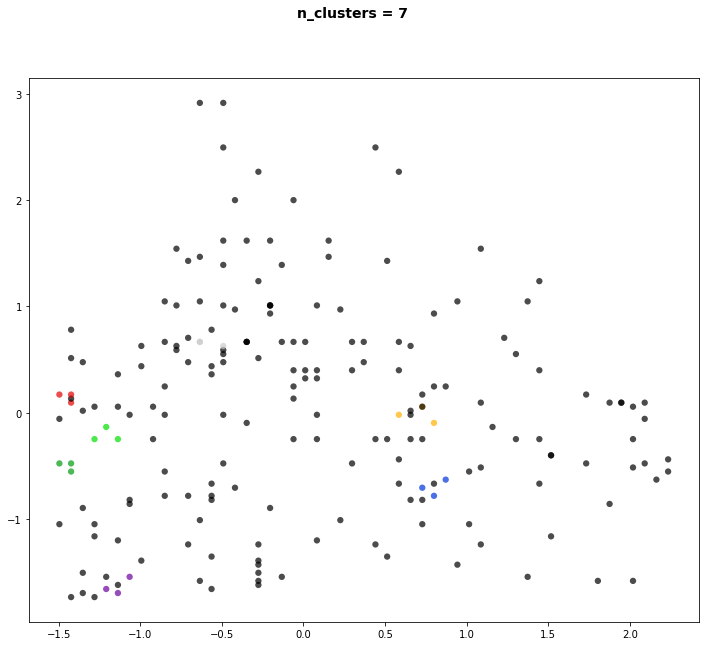

In [128]:
db_mc = DBSCAN(eps = 0.2, min_samples =3)
db_pred_m11 = db_mc.fit_predict(customers_scaled)
n_clusters1_ = len(set(db_pred_m11)) - (1 if -1 in db_pred_m11 else 0)
plt.figure(figsize=(12,10)) 
plt.scatter(customers_scaled[:, 0], customers_scaled[:, 1], c=db_pred_m11, 
 edgecolor='none', alpha=0.7, s=40, 
 cmap=plt.cm.get_cmap('nipy_spectral', 10)) 
plt.suptitle(("n_clusters = %d" % n_clusters1_),
                     fontsize=14, fontweight='bold')
print(silhouette_score(pred_tsne_cust,db_pred_m11))

# Часть 2. Понижение размерности и визуализация многомерных данных

Для отображения вам может быть полезна следующая функция plot_digits

In [35]:
def plot_digits(X, y, predicted_labels, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(predicted_labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

## Задание 2.1 Метод главных компонент

Примените к датасетам метод главных компонент и ответьте на следующие вопросы:
1. Сколько компонент объясняют 95% (99%) дисперсии данных в каждом из случаев?
2. Нарисуйте датасеты один с помощью plot_digits, customers с помощью plt.scatter как в статистике Хопкинса

В каких случаях мощи PCA достаточно для качественной отрисовки данных в 2D, а в каких нет?

In [36]:
from sklearn.decomposition import PCA

29


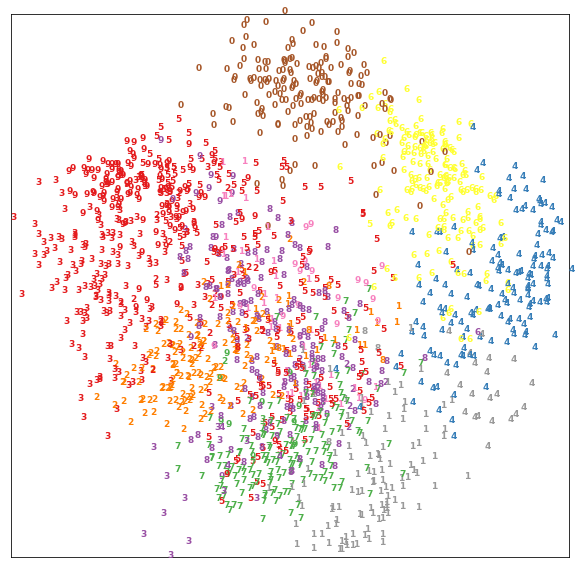

[179.0069301  163.71774688 141.78843909 101.1003752   69.51316559
  59.10852489  51.88453911  44.01510667  40.31099529  37.0117984
  28.51904118  27.32116981  21.90148814  21.32435654  17.63672222
  16.94686385  15.85138991  15.00446022  12.23447318  10.88685932
  10.69356625   9.58259779   9.2264026    8.69036872   8.3656119
   7.16577961   6.91973881   6.19295508   5.88499123]
0.2850936482369934


In [37]:
pca = PCA(0.95,random_state = 42)
X_mnist_new = pca.fit_transform(X_mnist)
print(pca.n_components_)
labels = AgglomerativeClustering(n_clusters= 10).fit_predict(X_mnist_new)
plot_digits(X_mnist_new, y_mnist, labels)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_[:2].sum())

4


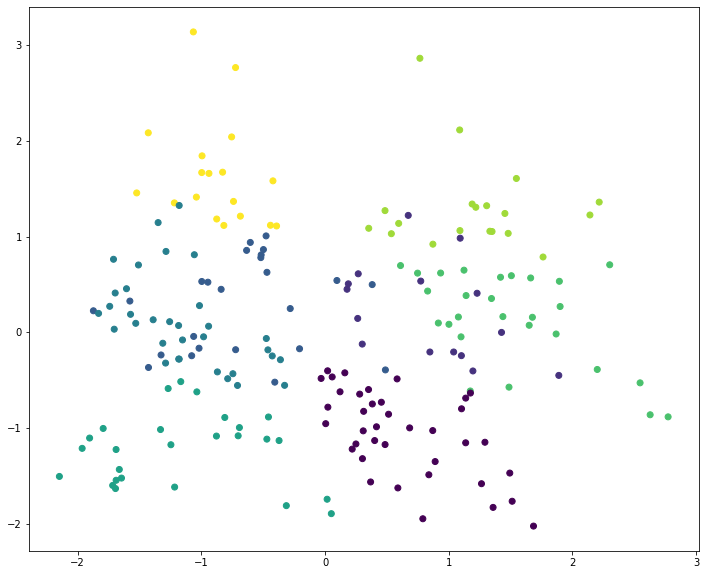

[1.35437369 1.05449828 0.93510105 0.67612749]
0.5992069019819848


In [38]:
pca = PCA(0.95,random_state = 10, svd_solver = 'full')
cust_new = pca.fit_transform(customers_scaled)
print(pca.n_components_)
plt.figure(figsize=(12,10))
plt.scatter(cust_new[:,0], cust_new[:,1], c=customer_pred)
plt.show()
print(pca.explained_variance_)
print(pca.explained_variance_ratio_[:2].sum())

## Задание 2.2 t-SNE (Student distributed Stochastic Neighbour Embedding)

Люди, которые ожидают оценку 9, должны немного разобраться в деталях t-SNE и уметь хотя бы на интуитивном уровне рассказать это преподавателю. Если вы претендуете на 8, то можно рассматривать t-sne как черный ящик, которому можно крутить параметры perplexity и learning_rate(в материалах можно встретить вариант epsilon). 

Источники информации:
1. https://distill.pub/2016/misread-tsne/
2. https://habr.com/ru/post/267041/
3. http://datareview.info/article/algoritm-t-sne-illyustrirovannyiy-vvodnyiy-kurs/

С помощью **!conda install -c conda-forge -y multicore-tsne** установите быструю версию t-sne.

Тут пример использования https://github.com/DmitryUlyanov/Multicore-TSNE


Если вдруг не получится, то используйте TSNE из sklearn. Но лучше, чтобы у вас получилось, так как будет нааааамного быстрее.

Проделайте с t-sne все то, что делали с PCA. Проведите эксперименты с разными значениями перплексии и скорости обучения (прям как в анимации с distill.pub).


**Провести различные эксперименты означает, что тут должно быть несколько рисунков с разными параметрами и какие-то выводы.**

In [ ]:
#!conda install -c conda-forge/label/cf202003 multicore-tsne

Solving environment: | 

In [33]:
from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE

<Figure size 864x720 with 0 Axes>

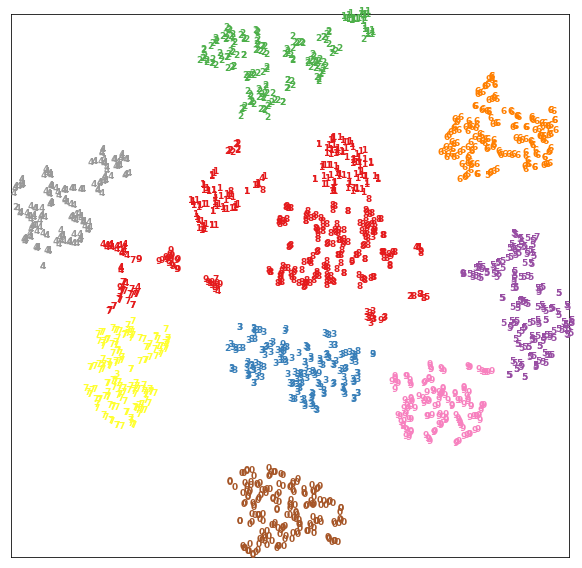

In [91]:
tsne = TSNE(random_state=42,learning_rate=400,perplexity=10)
pred_tsne = tsne.fit_transform(X_mnist_scaled) 
pred_2tsne = AgglomerativeClustering(n_clusters= 10).fit_predict(pred_tsne)

plt.figure(figsize=(12,10)) 
plot_digits(pred_tsne,y_mnist,pred_2tsne)

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<Figure size 864x720 with 0 Axes>

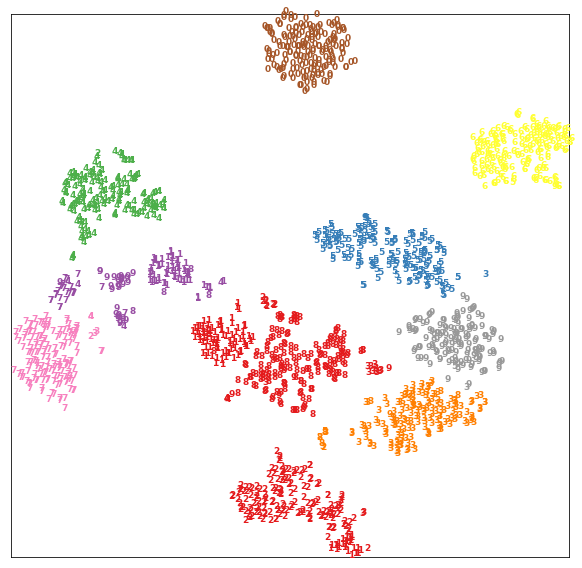

In [39]:
tsne = TSNE(random_state=42,learning_rate=450,perplexity=40)
pred_tsne = tsne.fit_transform(X_mnist_scaled) 
pred_2tsne = AgglomerativeClustering(n_clusters= 10).fit_predict(pred_tsne)

plt.figure(figsize=(12,10)) 
plot_digits(pred_tsne,y_mnist,pred_2tsne)

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


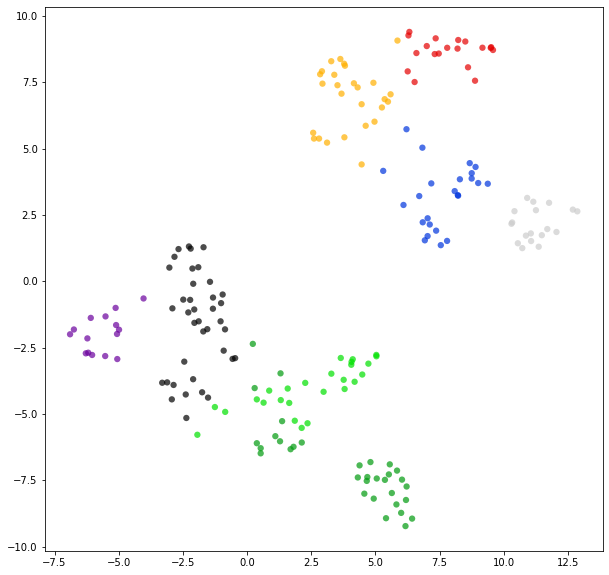

In [40]:
tsne = TSNE(random_state=42,learning_rate=480,perplexity=40)
pred_tsne_cust = tsne.fit_transform(customers_scaled) 
 
plt.figure(figsize=(10,10)) 
plt.scatter(pred_tsne_cust[:, 0], pred_tsne_cust[:, 1], c = customer_pred,
 edgecolor='none', alpha=0.7, s=40, 
 cmap=plt.cm.get_cmap('nipy_spectral', 10)) 

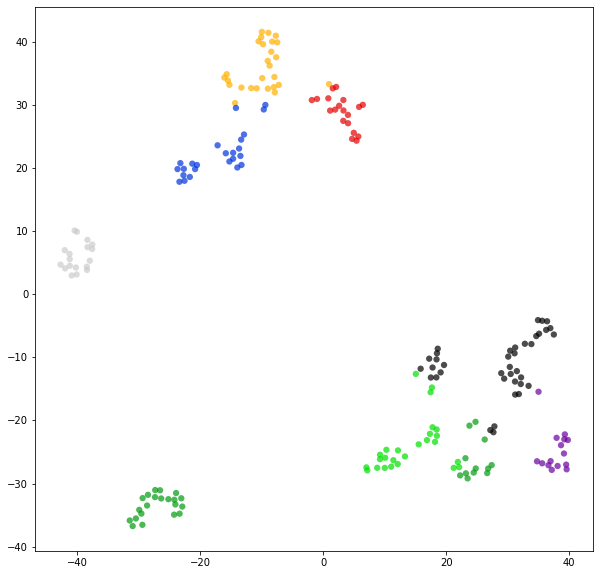

In [92]:
tsne = TSNE(random_state=42,learning_rate=400,perplexity=10)
pred_tsne_cust = tsne.fit_transform(customers_scaled) 
 
plt.figure(figsize=(10,10)) 
plt.scatter(pred_tsne_cust[:, 0], pred_tsne_cust[:, 1], c = customer_pred,
 edgecolor='none', alpha=0.7, s=40, 
 cmap=plt.cm.get_cmap('nipy_spectral', 10)) 

## Задание 2.3 (Вариант задания на 10). Серьезная критика t-SNE

Во многих статьях, которые я вам скидывал, к t-SNE советуют относиться очень аккуратно. А еще дальше пошел серьезный профессор пошел еще дальше и покритиковал t-SNE (и другой алгоритм UMAP) в приложении к биологическим данным еще сильнее и основательнее. В краткой форме он изложил свои претензии в следующем треде: https://twitter.com/lpachter/status/1431325969411821572.

Самым интересующимся студентам предлагается ознакомиться с этой информацией поподробнее, воспроизвести какие-то из аргументов и сделать соответствующие выводы.

## Задание 2.4. Кластеризация после понижения размерности

Используйте любой алгоритм кластеризации на ваш выбор и кластеризуйте данные пониженной размерности с помощью t-SNE. Сравните качество кластеризации с результатами на исходных датасетах. Обратите внимание, что мы это делаем только для наглядности и восприятия кластеризации, так как у нас получились двумерные данные. Использовать t-SNE для того, чтобы потом кластеризовать на его основе реальные данные не стоит, по причинам, которые описаны в https://distill.pub/2016/misread-tsne/, а также в опциональном задании 2.3.


Вопросы:
1. Каково значение статистики Хопкинса на данных пониженной размерности
2. Осталось ли таким-же наилучшее число кластеров?
3. В каком случае метрики качества кластеризации выше?


In [41]:
print('mnist: ', hopkins_statistic(pred_tsne))
print('customers: ', hopkins_statistic(pred_tsne_cust))

mnist:  0.1311630247133202
customers:  0.19406220936656715


For n_clusters = 5 The average silhouette_score is : 0.49646002


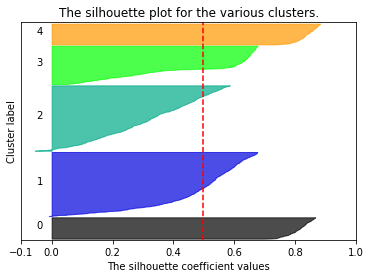

For n_clusters = 6 The average silhouette_score is : 0.5122546


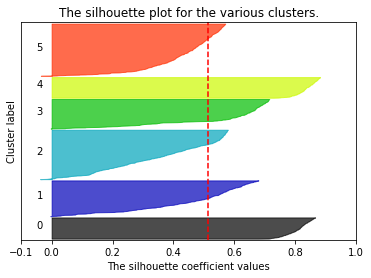

For n_clusters = 7 The average silhouette_score is : 0.5514684


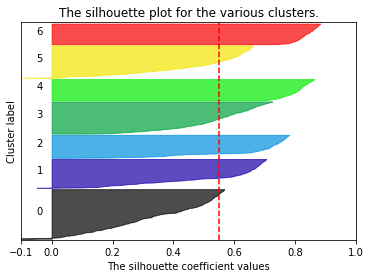

For n_clusters = 8 The average silhouette_score is : 0.6055829


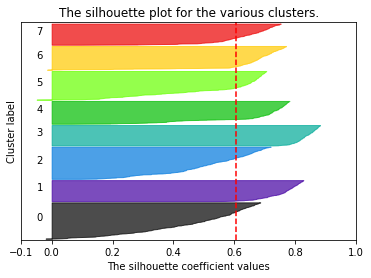

For n_clusters = 9 The average silhouette_score is : 0.60268414


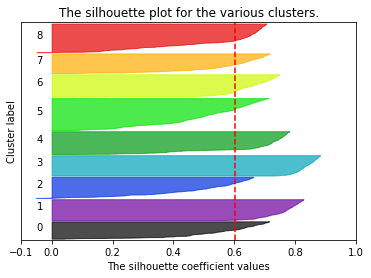

For n_clusters = 10 The average silhouette_score is : 0.59297097


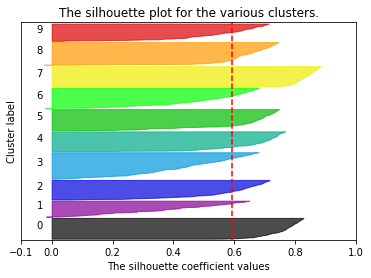

For n_clusters = 11 The average silhouette_score is : 0.5872545


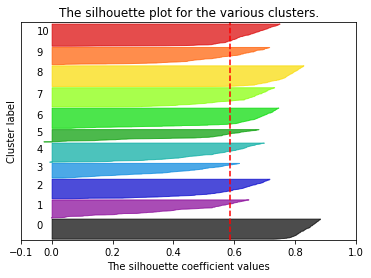

For n_clusters = 12 The average silhouette_score is : 0.57641476


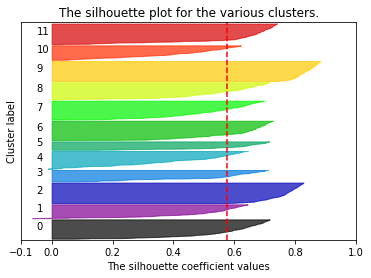

For n_clusters = 13 The average silhouette_score is : 0.5669196


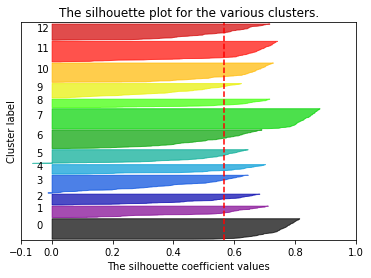

For n_clusters = 14 The average silhouette_score is : 0.53501827


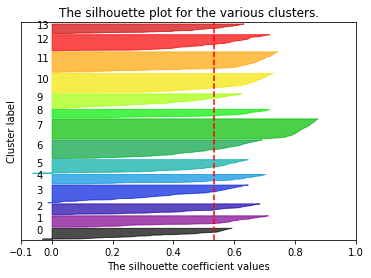

For n_clusters = 15 The average silhouette_score is : 0.51265794


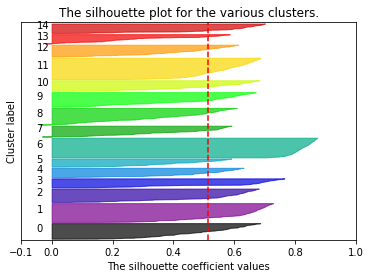

In [42]:
for i in range(5,16):
    kmeans_analysis(i,pred_tsne)

For n_clusters = 2 The average silhouette_score is : 0.57750654


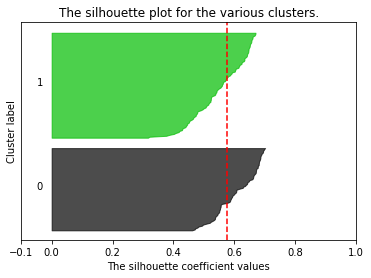

For n_clusters = 3 The average silhouette_score is : 0.56046504


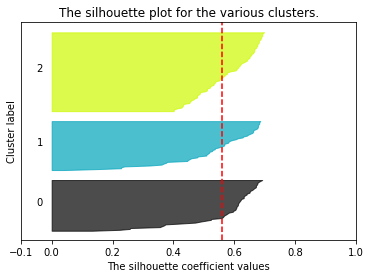

For n_clusters = 4 The average silhouette_score is : 0.54792017


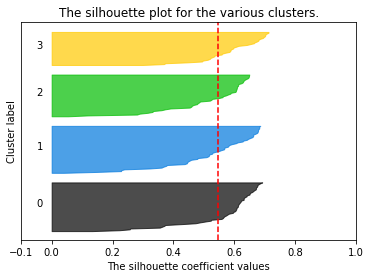

For n_clusters = 5 The average silhouette_score is : 0.52836436


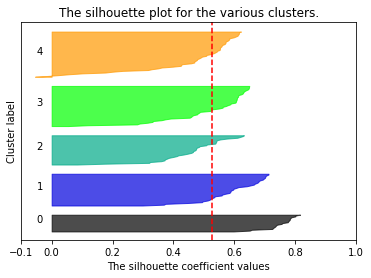

For n_clusters = 6 The average silhouette_score is : 0.5288324


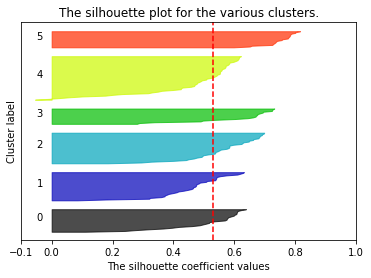

For n_clusters = 7 The average silhouette_score is : 0.5200977


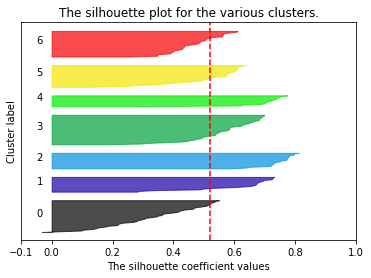

For n_clusters = 8 The average silhouette_score is : 0.5257258


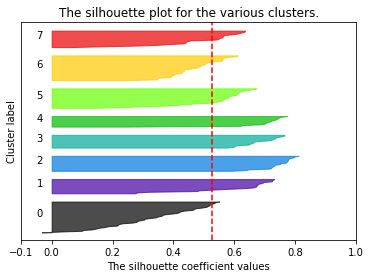

For n_clusters = 9 The average silhouette_score is : 0.5428177


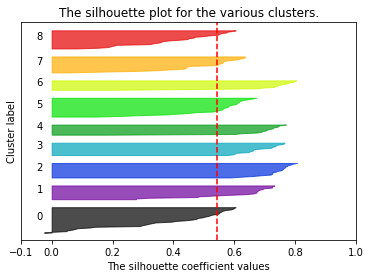

For n_clusters = 10 The average silhouette_score is : 0.57364875


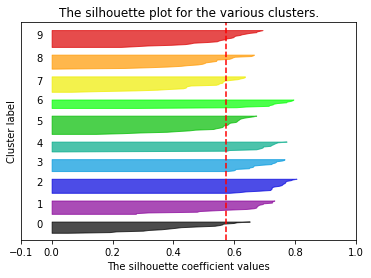

For n_clusters = 11 The average silhouette_score is : 0.5645812


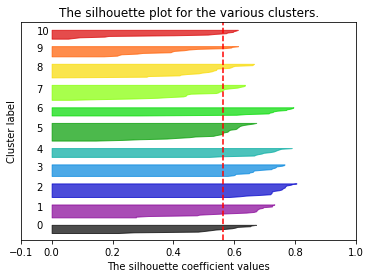

For n_clusters = 12 The average silhouette_score is : 0.5458029


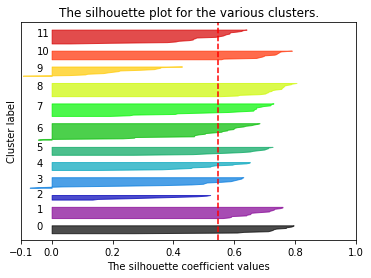

For n_clusters = 13 The average silhouette_score is : 0.5584662


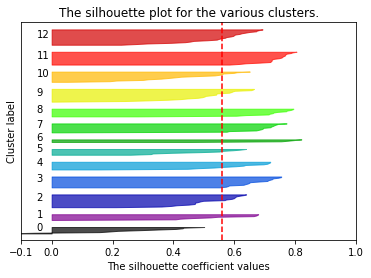

For n_clusters = 14 The average silhouette_score is : 0.55579966


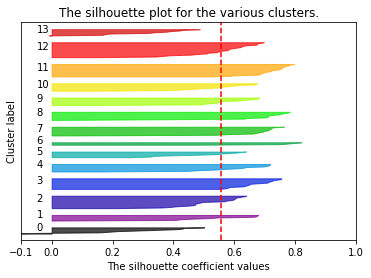

For n_clusters = 15 The average silhouette_score is : 0.51137143


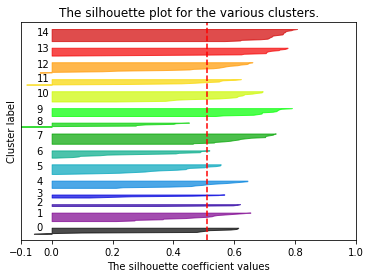

In [43]:
for i in range(2,16):
    kmeans_analysis(i,pred_tsne_cust)

# Задание 3 (второй вариант на 10). Реализация и анимация k-means

В этом задании вам предлагается реализовать метод кластеризации k-средних и снять на его основе короткометражный документальный фильм при помощи библиотеки **moviepy**. Все, что вам нужно - это получить "кадры" каждого шага метода и запустить соответствующую функцию. В конце нужно продемонстрировать процесс генерации и сам фильм преподавателю.

In [67]:
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage
import os

class MyKMeans():
    def __init__(self,n_centers,max_iter = 100, epsilon = 1e-6):
        self.n_centers = n_centers
        self.max_iterations = max_iter
        self.epsilon = epsilon
        
    def fit(self,X, string):
        self.cluster_oldcenters = X[np.random.randint(X.shape[0], size=self.n_centers), :]       
        self.clusters = np.array([np.linalg.norm(self.cluster_oldcenters-pt, axis=1).argmin() for pt in X])
        self.plot(X,0,string);
        self.cluster_newcenters = np.array([np.mean(X[np.where(self.clusters == i)[0]],axis = 0) for i in range(self.n_centers)])
        self.distances = [np.linalg.norm(self.cluster_oldcenters[i]-self.cluster_newcenters[i],axis = 0) for i in range(self.n_centers)]
        iteration = 1
        while iteration < self.max_iterations and max(self.distances) > self.epsilon:
            self.cluster_oldcenters = self.cluster_newcenters  
            self.clusters = np.array([np.linalg.norm(self.cluster_oldcenters-pt, axis=1).argmin() for pt in X])
            self.plot(X,iteration,string);
            self.cluster_newcenters = np.array([np.mean(X[np.where(self.clusters == i)[0]],axis = 0) for i in range(self.n_centers)])
            self.distances = [np.linalg.norm(self.cluster_oldcenters[i]-self.cluster_newcenters[i],axis = 0) for i in range(self.n_centers)]
            iteration += 1
        images = []
        for i in range(iteration):
            images.append(str(string)+ 'foo'+ str(i)+ '.png')
        clip = ImageSequenceClip(images,fps = 20)    
        clip.write_gif(str(string)+'demo.gif')
        clip.close()
        for i in range(iteration):
            os.remove(str(string)+'foo'+ str(i)+ '.png')
        
    def plot(self,X,iteration, string):
        plt.clf()
        plt.scatter(X[:,0], X[:,1], c=self.clusters,s = 10)
        plt.scatter(self.cluster_oldcenters[:,0], self.cluster_oldcenters[:,1],s = 30, c = 'black')
        plt.savefig(str(string)+ 'foo'+ str(iteration)+ '.png')
        

0.5066505529533332
MoviePy - Building file Xdemo.gif with imageio.


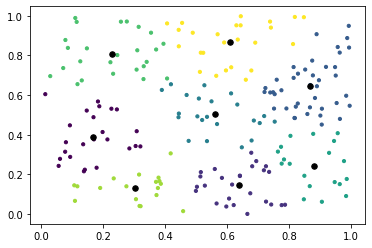

In [68]:
kmeans = MyKMeans(8)
X = np.random.random((200,2))
print(hopkins_statistic(X))
kmeans.fit(X,'X')

MoviePy - Building file customerdemo.gif with imageio.


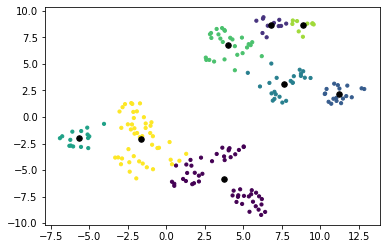

In [90]:
kmeans = MyKMeans(8)
kmeans.fit(pred_tsne_cust,'customer')

MoviePy - Building file mnistdemo.gif with imageio.


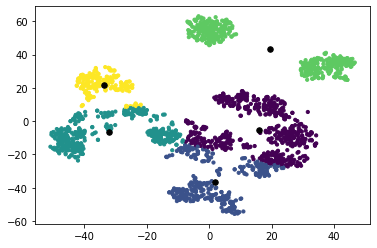

In [71]:
kmeans = MyKMeans(5)
kmeans.fit(pred_tsne,'mnist')

# Задание 4 (Третий вариант на 10. Сложнее). Ансамблировние алгоритмов кластеризации

За время выполнения лабораторной работы у вас получилось по крайней мере две кластеризации. Возникает логичный вопрос: а можем ли мы составить ансамбль из кластеризаций похоже на ансамбль supervised моделей?

В рамках этого размытого и творческого задания вам предлагается подумать о вариантах (или их нагуглить) и реализовать для комбинации k-means и иерархической кластеризации.

**Hint**. Ключевые слова: clustering ensemble, consensus clustering